#**Unsupervised pre-training vs Data Augmentation**

*Students:* --Valentina Barletta (Deep Learning) valentina.barletta@edu.unito.it --Sara De Benedetti (Reti Neurali) sara.debenedetti493@edu.unito.it

In [2]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)                                        # Check which device we got

cuda:0


In [ ]:
batch_size_train = 128
batch_size_test = 500

n_train = 2000
n_test = 500

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

## TRAIN SET

dataset_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=transform)


dataset_train.data, dataset_train.targets = dataset_train.data[:n_train], dataset_train.targets[:n_train]

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train,
                                            shuffle = True,  drop_last = True)

## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[:n_test], dataset_test.targets[:n_test]

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)



In [ ]:
input_dim = 28*28
hidden_dim = 10
out_dim = 10


class ConvolutionalNetwork(nn.Module):

  def __init__(self, input_dim, out_dim):

    super(ConvolutionalNetwork, self).__init__()

    self.conv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (3,3), stride = 1, padding  =1)     # <-- new layer
    self.act = nn.ReLU()

    self.flatten = nn.Flatten(1, 3)

    self.linear_layer = nn.Linear(input_dim, out_dim)                                                    # <-- we selected kernel size to have the same number of outputs
                                                                                                         #     after convolutional network
    self.soft = nn.Softmax(dim=1)

  def forward(self, x):

    x = self.conv(x)
    x = self.act(x)

    x = self.flatten(x)
    x = self.linear_layer(x)

    x = self.soft(x)

    return x


In [ ]:
model = ConvolutionalNetwork(input_dim, out_dim).to(device)

if device.type != "cpu":
  model = torch.compile(model)
else:
  model = torch.compile(model, mode = "max-autotune-no-cudagraphs", dynamic=True)

loss_function = nn.CrossEntropyLoss()

In [ ]:
def accuracy(y_pred, y):

  pred = y_pred.detach().argmax(dim=1)
  corrects = (pred == y)

  accuracy = (corrects.sum()/corrects.size(0)).float()

  return accuracy

def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

  acc_train, acc_test = 0, 0

  with torch.no_grad():

    for x_train, y_train in train_loader:

      x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

      out = model(x_train).squeeze()
      acc_train += accuracy(out, y_train)

    for x_test, y_test in test_loader:

      x_test, y_test = x_test.to(device), y_test.to(device)

      out = model(x_test).squeeze()
      acc_test += accuracy(out, y_test)

    acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

  return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100

def train(model, x, y):

  out = model(x)
  loss = loss_function(out.squeeze(), y)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()
  return float(loss)

if device.type != "cpu":
  accuracy = torch.compile(accuracy)
  train = torch.compile(train)
else:
  accuracy = torch.compile(accuracy, mode = "max-autotune-no-cudagraphs", dynamic=True)
  train = torch.compile(train, mode = "max-autotune-no-cudagraphs", dynamic=True)


In [ ]:
EPOCHS = 100

train_losses = []
train_accuracies = []
test_accuracies = []

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(EPOCHS):

  train_loss = 0

  ## TRAIN STEP

  for x_train, y_train in train_loader:

    x_train, y_train = x_train.to(device), y_train.to(device)


    loss = train(model, x_train, y_train)

    train_loss += loss

  train_loss /= len(train_loader)                    # we divide by the number of batches
  train_losses.append(train_loss)

  ## TEST STEP

  if epoch % 10 == 0:

    train_acc, test_acc = evaluate(model, train_loader, test_loader)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print("Epoch:", epoch, "Loss:", float(train_loss))


W0524 13:33:43.528000 131999718461440 torch/_logging/_internal.py:1013] [2/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored


Epoch: 0 Loss: 2.3023877143859863
Epoch: 10 Loss: 1.6530383984247843
Epoch: 20 Loss: 1.552112587292989
Epoch: 30 Loss: 1.5196398814519247
Epoch: 40 Loss: 1.5093586365381877
Epoch: 50 Loss: 1.5038091739018757
Epoch: 60 Loss: 1.4996153593063355
Epoch: 70 Loss: 1.4988478342692058
Epoch: 80 Loss: 1.49616383711497
Epoch: 90 Loss: 1.4957977930704753


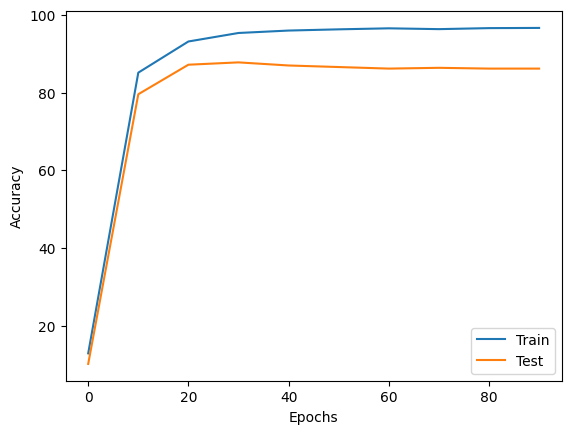

In [ ]:
epochs = [i*10 for i in range(EPOCHS//10)]

plt.plot(epochs, train_accuracies, label = "Train")
plt.plot(epochs, test_accuracies, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")


plt.legend()

plt.show()

**Autoencoder**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)                                        # Check which device we got

cpu


In [5]:
input_dim = (28 * 28)
hidden_dim = 10
out_dim = 10

MODEL_PATH = "models/autoencoder/"

class Autoencoder(nn.Module):
    def __init__(self, input_dim, out_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1, padding=1),  # 28 x 28 x 1 -> 28 x 28 x 8
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),  # 28 x 28 x 8 -> 14 x 14 x 8
                                    nn.Conv2d(8, 4, kernel_size=3, padding=1),  # 14 x 14 x 8 -> 14 x 14 x 4
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) # 14 x 14 x 4 -> 7 x 7 x 4


        # Decoder
        self.decoder = nn. Sequential(nn.Conv2d(4, 4, kernel_size=3, padding=1),  # 7 x 7 x 4 -> 7 x 7 x 4
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 7 x 7 x 4 -> 14 x 14 x 4
                                      nn.Conv2d(4, 8, kernel_size=3, padding=1),  # 14 x 14 x 4 -> 14 x 14 x 8
                                      nn.ReLU(),
                                      nn.Upsample(scale_factor=2, mode='nearest'),  # 14 x 14 x 8 -> 28 x 28 x 8
                                      nn.Conv2d(8, 1, kernel_size=3, padding=1),  # 28 x 28 x 8 -> 28 x 28 x 1
                                      nn.Sigmoid())  # Usa Sigmoid per ottenere valori tra 0 e 1

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


model = Autoencoder(input_dim, out_dim).to(device)


In [6]:
batch_size_train = 100
batch_size_test = 500

n_train = 60000
n_test = 500

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])

## TRAIN SET

dataset_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=transform)

dataset_train.data, dataset_train.targets = dataset_train.data[:n_train], dataset_train.targets[:n_train]

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size = batch_size_train,
                                            shuffle = True,  drop_last = True)

## TEST SET

dataset_test =  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=transform)

dataset_test.data, dataset_test.targets = dataset_test.data[:n_test], dataset_test.targets[:n_test]

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size = batch_size_test, shuffle = False)


Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./files/MNIST\raw\train-images-idx3-ubyte.gz to ./files/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./files/MNIST\raw\train-labels-idx1-ubyte.gz to ./files/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./files/MNIST\raw\t10k-images-idx3-ubyte.gz to ./files/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./files/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./files/MNIST\raw



In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 100

for epoch in range(EPOCHS):
  train_loss = 0
  for data in train_loader:
          img, _ = data
          img = img.to(device)
          optimizer.zero_grad()
          output = model(img)
          loss = criterion(output, img)
          loss.backward()
          optimizer.step()
  if epoch % 5== 0:
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, EPOCHS, loss.item()))

# Save the model
torch.save(model.state_dict(), 'model.pth')

Epoch [1/100], Loss: 0.5034
Epoch [6/100], Loss: 0.4804
Epoch [11/100], Loss: 0.4860
Epoch [16/100], Loss: 0.4966
Epoch [21/100], Loss: 0.4785
Epoch [26/100], Loss: 0.4810
Epoch [31/100], Loss: 0.4842
Epoch [36/100], Loss: 0.4844
Epoch [41/100], Loss: 0.4876
Epoch [46/100], Loss: 0.4959
Epoch [51/100], Loss: 0.4894
Epoch [56/100], Loss: 0.4848
Epoch [61/100], Loss: 0.5021
Epoch [66/100], Loss: 0.4790
Epoch [71/100], Loss: 0.4750
Epoch [76/100], Loss: 0.4916
Epoch [81/100], Loss: 0.4872
Epoch [86/100], Loss: 0.4748
Epoch [91/100], Loss: 0.4679
Epoch [96/100], Loss: 0.4619


<Figure size 1500x1000 with 0 Axes>

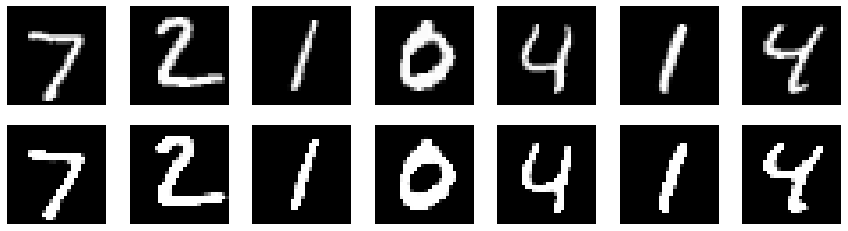

In [9]:
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break

import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
    ax[1, i].imshow(recon[i].cpu().numpy().squeeze(), cmap='gray')
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()


*Restore model used for unsupervised pre-training*

In [10]:
def accuracy(y_pred, y):

  pred = y_pred.detach().argmax(dim=1)
  corrects = (pred == y)

  accuracy = (corrects.sum()/corrects.size(0)).float()

  return accuracy

def evaluate(model, train_loader, test_loader):

  # initialize the accuracy as 0

  acc_train, acc_test = 0, 0

  with torch.no_grad():

    for x_train, y_train in train_loader:

      x_train, y_train = x_train.to(device), y_train.to(device)        # remember that we need to load our data into the GPUs

      out = model(x_train).squeeze()
      acc_train += accuracy(out, y_train)

    for x_test, y_test in test_loader:

      x_test, y_test = x_test.to(device), y_test.to(device)

      out = model(x_test).squeeze()
      acc_test += accuracy(out, y_test)

    acc_train, acc_test = acc_train / len(train_loader), acc_test / len(test_loader)

  return float(acc_train.detach()) * 100, float(acc_test.detach()) * 100

def train(model, x, y):

  out = model(x)
  loss = loss_function(out.squeeze(), y)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()
  return float(loss)

if device.type != "cpu":
  accuracy = torch.compile(accuracy)
  train = torch.compile(train)
else:
  accuracy = torch.compile(accuracy, mode = "max-autotune-no-cudagraphs", dynamic=True)
  train = torch.compile(train, mode = "max-autotune-no-cudagraphs", dynamic=True)


AttributeError: module 'torch' has no attribute 'compile'

In [ ]:
pretrained_autoencoder = model
pretrained_autoencoder.load_state_dict(torch.load('model.pth'))
# pretrained_autoencoder.eval()

In [ ]:
from torchsummary import summary

# Usare la funzione summary per visualizzare un riassunto del modello
summary(pretrained_autoencoder, input_size=(1, 28, 28))


In [ ]:
class EncoderWithSoftmax(nn.Module):
    def __init__(self, pretrained_autoencoder):
        super(EncoderWithSoftmax, self).__init__()

        # Estraggo l'encoder dal modello preaddestrato
        self.encoder = pretrained_autoencoder.encoder

        # Calcola la dimensione dell'output flatten
        self.encoder_output_dim = self._get_encoder_output_dim()
        flattened_dim = self.encoder_output_dim[1] * self.encoder_output_dim[2] * self.encoder_output_dim[3]

        # Applico il softmax come ultimo layer
        self.encoder_with_softmax = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flattened_dim, out_features=10),
            nn.Softmax(dim=1)  # Applica softmax lungo la dimensione 1
        )

    def _get_encoder_output_dim(self):
        with torch.no_grad():
            # Crea un input fittizio con la dimensione del batch e canali appropriati
            dummy_input = torch.randn(1, 1, 28, 28).to(next(self.encoder.parameters()).device)  # Batch size di 1, 1 canale, 28x28 dimensione dell'immagine
            output = self.encoder(dummy_input)
        return output.shape

    def forward(self, x):
        x = self.encoder(x)
        x = self.encoder_with_softmax(x)
        return x

# Supponiamo di avere un autoencoder preaddestrato chiamato pretrained_autoencoder
pretrained_autoencoder = Autoencoder(input_dim, out_dim).to(device)

model = EncoderWithSoftmax(pretrained_autoencoder).to(device)
loss_function = nn.CrossEntropyLoss()


In [ ]:
EPOCHS = 100

train_losses = []
train_accuracies = []
test_accuracies = []

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(EPOCHS):

  train_loss = 0

  ## TRAIN STEP

  for x_train, y_train in train_loader:

    x_train, y_train = x_train.to(device), y_train.to(device)
    loss = train(model, x_train, y_train)
    train_loss += loss

  train_loss /= len(train_loader)                    # we divide by the number of batches
  train_losses.append(train_loss)

  ## TEST STEP

  if epoch % 10 == 0:

    train_acc, test_acc = evaluate(model, train_loader, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print("Epoch:", epoch, "Loss:", float(train_loss))


In [ ]:
epochs = [i*10 for i in range(EPOCHS//10)]

plt.plot(epochs, train_accuracies, label = "Train")
plt.plot(epochs, test_accuracies, label = "Test")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")


plt.legend()

plt.show()